## 数据预处理

In [1]:
from torchvision.datasets import ImageFolder
import numpy as np
import torch


# 设置随机数生成器种子
seed = 24
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# 数据集根目录
# data_root = './data/sub_img_dataset/coating_shape'  # 子图数据集
# data_root = './data/color_dataset/coating_color' # 颜色数据集
data_root = './data/dataset_new/coating_color'
dataset = ImageFolder(root=data_root)

class_names = dataset.classes

print(len(dataset))
print(dataset.class_to_idx)
print(dataset[0])

91
{'bai_tai': 0, 'huang_tai': 1}
(<PIL.Image.Image image mode=RGB size=1343x1420 at 0x235A31BEDD0>, 0)


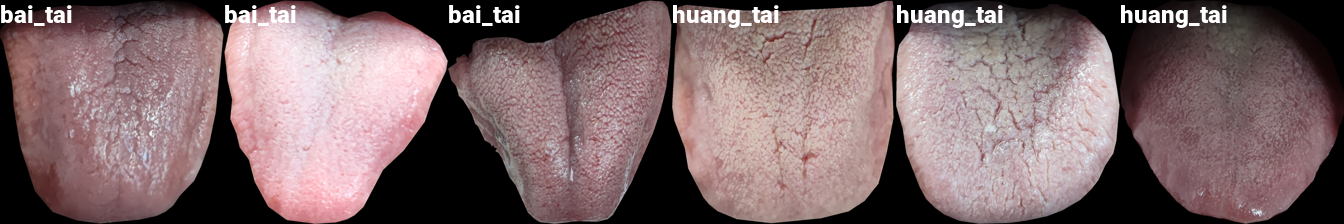

In [2]:
from PIL import Image, ImageDraw, ImageFont
import os
import random


def show_examples(dataset: ImageFolder, examples_per_class=3, size=(224, 224)):
    w, h = size
    labels = dataset.classes
    num_classes = len(labels)

    # 每行至多显示的类别数量
    max_classes_per_row = 2
    # 计算每行显示的示例数量
    examples_per_row = min(
        examples_per_class * max_classes_per_row, num_classes * examples_per_class)
    # 计算显示示例的行数
    num_rows = num_classes * examples_per_class // examples_per_row + (1 if num_classes * examples_per_class % examples_per_row != 0 else 0)
    # 计算网格图像的大小
    grid_size = (examples_per_row * w, num_rows * h)

    grid = Image.new('RGB', size=grid_size, color=(255, 255, 255))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype(
        "C:\\Users\\ChenXi\\fonts\\Roboto\\Roboto-Black.ttf", 24)

    for row in range(num_rows):
        for col in range(max_classes_per_row):
            label_id = row * max_classes_per_row + col
            if label_id >= num_classes:
                break

            label = labels[label_id]

            # 获取该类别的所有图片路径
            class_images = [img_path for img_path,
                            class_label in dataset.imgs if class_label == label_id]

            # 从该类别的所有图片中随机选择 examples_per_class 张图片
            selected_images = random.sample(class_images, min(
                examples_per_class, len(class_images)))

            # 在当前类别的行中绘制图片和标签
            for i, img_path in enumerate(selected_images):
                image = Image.open(img_path)

                # 读取图像的 Exif 信息，获取方向信息
                exif = image._getexif()
                orientation = exif.get(0x0112, 1) if exif else 1

                # 根据方向信息旋转图像
                if orientation == 1:
                    pass
                elif orientation == 3:
                    image = image.rotate(180, expand=True)
                elif orientation == 6:
                    image = image.rotate(270, expand=True)
                elif orientation == 8:
                    image = image.rotate(90, expand=True)

                image = image.resize(size)
                idx = col * examples_per_class + i
                box = (idx * w, row * h)
                grid.paste(image, box=box)
                draw.text(box, label, (255, 255, 255), font=font)  # 在图片上方写标签

    return grid


# 显示数据集示例
show_examples(dataset)

In [3]:
from torchvision.transforms import transforms
from torch.utils.data import DataLoader


dataset_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
data_loader.dataset.transform = dataset_transform
# 获取所有图像数据
all_images = None

for inputs, _ in data_loader:
    all_images = inputs

# 计算数据集的均值和标准差
mean = torch.mean(all_images, dim=(0, 2, 3))
std = torch.std(all_images, dim=(0, 2, 3))

print(f"均值：{mean}")
print(f"标准差：{std}")

均值：tensor([0.4824, 0.4077, 0.4209])
标准差：tensor([0.2914, 0.2609, 0.2684])


In [4]:
from torch.utils.data import random_split
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import TensorDataset


class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0

        mask = torch.from_numpy(mask)
        img *= mask.unsqueeze(0)

        return img
    

# 数据增强和预处理
data_augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomApply(transforms.GaussianBlur(3, sigma=(0.1, 2.0)), 0.5),
    Cutout(n_holes=8, length=32),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


# # 计算每个类别的样本数量
# class_counts = torch.bincount(torch.tensor(dataset.targets))

# # 计算每个类别的权重
# class_weights = 1 / class_counts.float()


# 划分数据集
train_size = int(4 / 6.0 * len(dataset))
val_size = int(1 / 6.0 * len(dataset))
test_size = len(dataset) - train_size - val_size
remaining_size = len(dataset) - train_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = data_augmentation_transform
val_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

# 获取训练集的特征和标签
X_train = []
y_train = []
for inputs, labels in train_dataset:
    X_train.append(inputs.numpy())  # 将张量转换为 numpy 数组
    y_train.append(labels)
X_train = np.array(X_train)
y_train = np.array(y_train)

# 创建 RandomOverSampler 实例
ros = RandomOverSampler(random_state=24)

# 进行过采样
X_resampled, y_resampled = ros.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

# 将特征转换回张量形式
X_resampled = torch.tensor(X_resampled.reshape(-1, *inputs.shape))

# 创建过采样后的训练集
oversampled_train_dataset = TensorDataset(X_resampled, torch.tensor(y_resampled))

# 创建 DataLoader
train_loader = DataLoader(oversampled_train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [5]:
# 输出数据集大小
print("过采样后的训练集大小:", len(oversampled_train_dataset))
print("验证集大小:", len(val_dataset))
print("测试集大小:", len(test_dataset))

id2label = {id: label for id, label in enumerate(
    train_dataset.dataset.classes)}
label2id = {label: id for id, label in id2label.items()}

过采样后的训练集大小: 82
验证集大小: 15
测试集大小: 16


In [6]:
from transformers import ViTImageProcessor


# 加载 Vision Transformer 的特征提取器
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTImageProcessor.from_pretrained(
    model_name,
    do_normalize=False,
    do_resize=False,
    do_rescale=False,
    )
# feature_extractor.image_mean = mean
# feature_extractor.image_std = std
feature_extractor

ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": false,
  "do_rescale": false,
  "do_resize": false,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


def custom_collate(batch):

    # 将样本数据列表拆分为输入和标签
    images, labels = list(zip(*batch))
    inputs = feature_extractor(images, return_tensors='pt')

    inputs['labels'] = torch.tensor(labels)
    inputs['pixel_values'] = torch.stack(
        [input for input in inputs["pixel_values"]])
    return inputs


train_data = MyDataset(train_dataset)
val_data=MyDataset(val_dataset)
test_data=MyDataset(test_dataset)

In [8]:
from transformers import ViTForImageClassification

model_name = "./tongue-disease-classification/coating_color/checkpoint_on_color"

# model_name 是官方的 transformer 预训练模型

model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(dataset.classes), id2label=id2label,label2id=label2id)

In [9]:
from sklearn.metrics import accuracy_score


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)     
    return dict(accuracy=accuracy_score(predictions, labels))
    # logits, labels = eval_pred
    # predictions = logits.argsort(axis=-1)[:, -5:]  # 获取top-5预测结果
    # # 将标签扩展为与预测结果相同的形状
    # labels_expanded = labels.reshape(-1, 1).repeat(5, axis=1)
    # correct_predictions = (predictions == labels_expanded)  # 判断预测结果是否包含正确标签
    # top5_accuracy = correct_predictions.any(axis=-1).mean()  # 计算top-5准确率
    # return {"accuracy": top5_accuracy}

In [10]:
from transformers import TrainingArguments, Trainer


def train(train_dataset: Dataset,
          valid_dataset: Dataset,
          pre_model_path: str
          ) -> None:
    """[summary]

    Args:
        train_dataset (Dataset): [训练集]
        valid_dataset (Dataset): [验证集]
        pre_model_path (str): [预训练模型文件夹]

    Returns:
        [type]: [description]
    """

    args = TrainingArguments(
        report_to="none",
        output_dir=f"tongue-disease-classification/coating_color/final_model",
        remove_unused_columns=False,
        save_strategy="epoch",
        evaluation_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=30,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_dir='logs',
        warmup_ratio=0.1,
        logging_steps=10,
        seed=seed,
    )

    # 每次训练都要重新载入模型，定义一个函数返回初始化的预训练模型
    def model_init():
        return ViTForImageClassification.from_pretrained(pre_model_path, num_labels=len(dataset.classes), id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

    # 定义一个trainer
    trainer = Trainer(
        # 注意此处不是model
        model_init=model_init,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        data_collator=custom_collate,
        compute_metrics=compute_metrics,
        tokenizer=feature_extractor,
    )

    # 超参数搜索范围
    def hp_space(trial):
        return {
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
            "weight_decay": trial.suggest_float("weight_decay", 0.01, 0.3),
            "num_train_epochs": trial.suggest_int("num_train_epochs", 8, 20),
            "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32]),
        }

    # trainer.hyperparameter_search方法进行超参数搜索
    best_trial = trainer.hyperparameter_search(
        direction="maximize",
        backend="optuna",
        n_trials=12,
        hp_space=hp_space,
    )

    print("*************************************")
    print(" Best run %s" % str(best_trial))
    print("*************************************")


train_results = train(train_data, val_data, model_name)

c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
[I 2024-05-09 13:59:44,491] A new study created in memory with name: no-name-888de895-7a0e-46ac-8e66-489a6906a788


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.9221714735031128, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.3837, 'eval_samples_per_second': 39.092, 'eval_steps_per_second': 5.212, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8715475797653198, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.3704, 'eval_samples_per_second': 40.496, 'eval_steps_per_second': 5.399, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6485944390296936, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.3702, 'eval_samples_per_second': 40.518, 'eval_steps_per_second': 5.402, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5975607633590698, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.3695, 'eval_samples_per_second': 40.601, 'eval_steps_per_second': 5.413, 'epoch': 4.0}
{'loss': 1.3571, 'grad_norm': 1.3008832931518555, 'learning_rate': 8.528012547396853e-06, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5853407979011536, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3662, 'eval_samples_per_second': 40.963, 'eval_steps_per_second': 5.462, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.584270715713501, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3758, 'eval_samples_per_second': 39.918, 'eval_steps_per_second': 5.322, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5857096314430237, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3738, 'eval_samples_per_second': 40.124, 'eval_steps_per_second': 5.35, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5857347249984741, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.368, 'eval_samples_per_second': 40.76, 'eval_steps_per_second': 5.435, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5851293206214905, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3719, 'eval_samples_per_second': 40.337, 'eval_steps_per_second': 5.378, 'epoch': 9.0}
{'loss': 0.531, 'grad_norm': 1.1832153797149658, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5845564603805542, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3697, 'eval_samples_per_second': 40.574, 'eval_steps_per_second': 5.41, 'epoch': 10.0}


[I 2024-05-09 14:00:21,078] Trial 0 finished with value: 0.6666666666666666 and parameters: {'learning_rate': 1.5350422585314334e-05, 'weight_decay': 0.08650865311202466, 'num_train_epochs': 10, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.6666666666666666.


{'train_runtime': 34.575, 'train_samples_per_second': 17.354, 'train_steps_per_second': 0.578, 'train_loss': 0.9440079689025879, 'epoch': 10.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 2.0482611656188965, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.366, 'eval_samples_per_second': 40.981, 'eval_steps_per_second': 5.464, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.0810182094573975, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.3671, 'eval_samples_per_second': 40.866, 'eval_steps_per_second': 5.449, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.761009156703949, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.377, 'eval_samples_per_second': 39.784, 'eval_steps_per_second': 5.305, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.655768632888794, 'eval_accuracy': 0.4666666666666667, 'eval_runtime': 0.3715, 'eval_samples_per_second': 40.378, 'eval_steps_per_second': 5.384, 'epoch': 4.0}
{'loss': 1.4868, 'grad_norm': 2.251258611679077, 'learning_rate': 4.821962326911862e-06, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6154424548149109, 'eval_accuracy': 0.8666666666666667, 'eval_runtime': 0.3681, 'eval_samples_per_second': 40.748, 'eval_steps_per_second': 5.433, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5975269675254822, 'eval_accuracy': 0.8, 'eval_runtime': 0.3737, 'eval_samples_per_second': 40.136, 'eval_steps_per_second': 5.351, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5892850756645203, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.379, 'eval_samples_per_second': 39.576, 'eval_steps_per_second': 5.277, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5862683057785034, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.54, 'eval_samples_per_second': 27.778, 'eval_steps_per_second': 3.704, 'epoch': 8.0}


[I 2024-05-09 14:00:47,525] Trial 1 finished with value: 0.6666666666666666 and parameters: {'learning_rate': 1.1251245429461012e-05, 'weight_decay': 0.18397361995377984, 'num_train_epochs': 8, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.6666666666666666.


{'train_runtime': 25.8783, 'train_samples_per_second': 18.548, 'train_steps_per_second': 0.618, 'train_loss': 1.166968822479248, 'epoch': 8.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/150 [00:00<?, ?it/s]

{'loss': 1.6085, 'grad_norm': 5.6818437576293945, 'learning_rate': 2.9516672625483028e-05, 'epoch': 0.67}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7143808603286743, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3862, 'eval_samples_per_second': 38.843, 'eval_steps_per_second': 5.179, 'epoch': 1.0}
{'loss': 0.5161, 'grad_norm': 4.696599006652832, 'learning_rate': 4.263519379236437e-05, 'epoch': 1.33}
{'loss': 0.701, 'grad_norm': 2.106703758239746, 'learning_rate': 3.935556350064403e-05, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6441661715507507, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.375, 'eval_samples_per_second': 40.003, 'eval_steps_per_second': 5.334, 'epoch': 2.0}
{'loss': 0.4565, 'grad_norm': 2.768617630004883, 'learning_rate': 3.60759332089237e-05, 'epoch': 2.67}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5015188455581665, 'eval_accuracy': 0.6, 'eval_runtime': 0.3851, 'eval_samples_per_second': 38.953, 'eval_steps_per_second': 5.194, 'epoch': 3.0}
{'loss': 0.3892, 'grad_norm': 2.9241833686828613, 'learning_rate': 3.279630291720336e-05, 'epoch': 3.33}
{'loss': 0.2273, 'grad_norm': 3.505467653274536, 'learning_rate': 2.9516672625483028e-05, 'epoch': 4.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5274093151092529, 'eval_accuracy': 0.6, 'eval_runtime': 0.3743, 'eval_samples_per_second': 40.074, 'eval_steps_per_second': 5.343, 'epoch': 4.0}
{'loss': 0.0869, 'grad_norm': 0.4505993723869324, 'learning_rate': 2.623704233376269e-05, 'epoch': 4.67}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.833716094493866, 'eval_accuracy': 0.6, 'eval_runtime': 0.401, 'eval_samples_per_second': 37.405, 'eval_steps_per_second': 4.987, 'epoch': 5.0}
{'loss': 0.0908, 'grad_norm': 0.48308974504470825, 'learning_rate': 2.2957412042042353e-05, 'epoch': 5.33}
{'loss': 0.0198, 'grad_norm': 0.5203471779823303, 'learning_rate': 1.9677781750322016e-05, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6042357087135315, 'eval_accuracy': 0.8, 'eval_runtime': 0.3975, 'eval_samples_per_second': 37.739, 'eval_steps_per_second': 5.032, 'epoch': 6.0}
{'loss': 0.0112, 'grad_norm': 0.22887824475765228, 'learning_rate': 1.639815145860168e-05, 'epoch': 6.67}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6344931721687317, 'eval_accuracy': 0.8, 'eval_runtime': 0.3815, 'eval_samples_per_second': 39.318, 'eval_steps_per_second': 5.242, 'epoch': 7.0}
{'loss': 0.0079, 'grad_norm': 0.08363670855760574, 'learning_rate': 1.3118521166881344e-05, 'epoch': 7.33}
{'loss': 0.0078, 'grad_norm': 0.05727599188685417, 'learning_rate': 9.838890875161008e-06, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.666295051574707, 'eval_accuracy': 0.8, 'eval_runtime': 0.381, 'eval_samples_per_second': 39.366, 'eval_steps_per_second': 5.249, 'epoch': 8.0}
{'loss': 0.0069, 'grad_norm': 0.055300112813711166, 'learning_rate': 6.559260583440672e-06, 'epoch': 8.67}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6628559231758118, 'eval_accuracy': 0.8, 'eval_runtime': 0.384, 'eval_samples_per_second': 39.059, 'eval_steps_per_second': 5.208, 'epoch': 9.0}
{'loss': 0.0062, 'grad_norm': 0.08061981201171875, 'learning_rate': 3.279630291720336e-06, 'epoch': 9.33}
{'loss': 0.0055, 'grad_norm': 0.050984617322683334, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6628711223602295, 'eval_accuracy': 0.8, 'eval_runtime': 0.3903, 'eval_samples_per_second': 38.43, 'eval_steps_per_second': 5.124, 'epoch': 10.0}


[I 2024-05-09 14:01:25,045] Trial 2 finished with value: 0.8 and parameters: {'learning_rate': 4.427500893822454e-05, 'weight_decay': 0.28319664186756505, 'num_train_epochs': 10, 'per_device_train_batch_size': 4}. Best is trial 2 with value: 0.8.


{'train_runtime': 36.7376, 'train_samples_per_second': 16.332, 'train_steps_per_second': 4.083, 'train_loss': 0.2761063922693332, 'epoch': 10.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 2.121755838394165, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.3995, 'eval_samples_per_second': 37.548, 'eval_steps_per_second': 5.006, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.0931624174118042, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.3974, 'eval_samples_per_second': 37.746, 'eval_steps_per_second': 5.033, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.658313512802124, 'eval_accuracy': 0.4666666666666667, 'eval_runtime': 0.3988, 'eval_samples_per_second': 37.614, 'eval_steps_per_second': 5.015, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5951215028762817, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3949, 'eval_samples_per_second': 37.981, 'eval_steps_per_second': 5.064, 'epoch': 4.0}
{'loss': 1.4545, 'grad_norm': 1.282502293586731, 'learning_rate': 1.4775085114261017e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5918573141098022, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3836, 'eval_samples_per_second': 39.107, 'eval_steps_per_second': 5.214, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6017100214958191, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3873, 'eval_samples_per_second': 38.733, 'eval_steps_per_second': 5.164, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6045234203338623, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3824, 'eval_samples_per_second': 39.227, 'eval_steps_per_second': 5.23, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5988003611564636, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3808, 'eval_samples_per_second': 39.392, 'eval_steps_per_second': 5.252, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5912759304046631, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3779, 'eval_samples_per_second': 39.691, 'eval_steps_per_second': 5.292, 'epoch': 9.0}
{'loss': 0.481, 'grad_norm': 1.21384596824646, 'learning_rate': 9.49826900202494e-06, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5883092284202576, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3826, 'eval_samples_per_second': 39.203, 'eval_steps_per_second': 5.227, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5906127691268921, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3789, 'eval_samples_per_second': 39.593, 'eval_steps_per_second': 5.279, 'epoch': 11.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.59189373254776, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3763, 'eval_samples_per_second': 39.865, 'eval_steps_per_second': 5.315, 'epoch': 12.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5924206376075745, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3698, 'eval_samples_per_second': 40.562, 'eval_steps_per_second': 5.408, 'epoch': 13.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5944051146507263, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.383, 'eval_samples_per_second': 39.164, 'eval_steps_per_second': 5.222, 'epoch': 14.0}
{'loss': 0.3086, 'grad_norm': 1.2321265935897827, 'learning_rate': 4.221452889788862e-06, 'epoch': 15.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5962404608726501, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3862, 'eval_samples_per_second': 38.84, 'eval_steps_per_second': 5.179, 'epoch': 15.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5963751673698425, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3864, 'eval_samples_per_second': 38.82, 'eval_steps_per_second': 5.176, 'epoch': 16.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5962293148040771, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3796, 'eval_samples_per_second': 39.515, 'eval_steps_per_second': 5.269, 'epoch': 17.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5952233672142029, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3794, 'eval_samples_per_second': 39.539, 'eval_steps_per_second': 5.272, 'epoch': 18.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5948551893234253, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3705, 'eval_samples_per_second': 40.488, 'eval_steps_per_second': 5.398, 'epoch': 19.0}


[I 2024-05-09 14:02:26,780] Trial 3 finished with value: 0.6666666666666666 and parameters: {'learning_rate': 1.7941174781602663e-05, 'weight_decay': 0.17358905173285483, 'num_train_epochs': 19, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 0.8.


{'train_runtime': 60.9835, 'train_samples_per_second': 18.694, 'train_steps_per_second': 0.623, 'train_loss': 0.6380421707504674, 'epoch': 19.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.3228304386138916, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.379, 'eval_samples_per_second': 39.582, 'eval_steps_per_second': 5.278, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6064844131469727, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.3879, 'eval_samples_per_second': 38.665, 'eval_steps_per_second': 5.155, 'epoch': 2.0}
{'loss': 1.5352, 'grad_norm': 1.6015645265579224, 'learning_rate': 2.3259062292755913e-05, 'epoch': 2.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6258680820465088, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3809, 'eval_samples_per_second': 39.383, 'eval_steps_per_second': 5.251, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6258094906806946, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3844, 'eval_samples_per_second': 39.023, 'eval_steps_per_second': 5.203, 'epoch': 4.0}
{'loss': 0.5219, 'grad_norm': 2.600125789642334, 'learning_rate': 1.9248879138832482e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.607619047164917, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3795, 'eval_samples_per_second': 39.523, 'eval_steps_per_second': 5.27, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6028721332550049, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3822, 'eval_samples_per_second': 39.245, 'eval_steps_per_second': 5.233, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5886828303337097, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.376, 'eval_samples_per_second': 39.897, 'eval_steps_per_second': 5.32, 'epoch': 7.0}
{'loss': 0.2946, 'grad_norm': 1.352060317993164, 'learning_rate': 1.5238695984909049e-05, 'epoch': 7.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6223501563072205, 'eval_accuracy': 0.6, 'eval_runtime': 0.3806, 'eval_samples_per_second': 39.408, 'eval_steps_per_second': 5.254, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6167625188827515, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.3821, 'eval_samples_per_second': 39.254, 'eval_steps_per_second': 5.234, 'epoch': 9.0}
{'loss': 0.1447, 'grad_norm': 0.6457380056381226, 'learning_rate': 1.1228512830985614e-05, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5830085873603821, 'eval_accuracy': 0.6, 'eval_runtime': 0.3841, 'eval_samples_per_second': 39.052, 'eval_steps_per_second': 5.207, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5943434238433838, 'eval_accuracy': 0.6, 'eval_runtime': 0.3732, 'eval_samples_per_second': 40.197, 'eval_steps_per_second': 5.36, 'epoch': 11.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6116654276847839, 'eval_accuracy': 0.6, 'eval_runtime': 0.3806, 'eval_samples_per_second': 39.414, 'eval_steps_per_second': 5.255, 'epoch': 12.0}
{'loss': 0.0671, 'grad_norm': 0.6321320533752441, 'learning_rate': 7.218329677062181e-06, 'epoch': 12.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6042056679725647, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3756, 'eval_samples_per_second': 39.933, 'eval_steps_per_second': 5.324, 'epoch': 13.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5828723311424255, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3852, 'eval_samples_per_second': 38.938, 'eval_steps_per_second': 5.192, 'epoch': 14.0}
{'loss': 0.0411, 'grad_norm': 0.76523756980896, 'learning_rate': 3.208146523138747e-06, 'epoch': 15.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.584273636341095, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3808, 'eval_samples_per_second': 39.387, 'eval_steps_per_second': 5.252, 'epoch': 15.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5823342204093933, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3738, 'eval_samples_per_second': 40.131, 'eval_steps_per_second': 5.351, 'epoch': 16.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.58172607421875, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.3789, 'eval_samples_per_second': 39.586, 'eval_steps_per_second': 5.278, 'epoch': 17.0}


[I 2024-05-09 14:03:22,087] Trial 4 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 2.4462117238932945e-05, 'weight_decay': 0.1927146650899884, 'num_train_epochs': 17, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 0.8.


{'train_runtime': 54.6377, 'train_samples_per_second': 18.668, 'train_steps_per_second': 1.245, 'train_loss': 0.3869786512325792, 'epoch': 17.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-05-09 14:03:25,445] Trial 5 pruned. 


{'eval_loss': 0.6699081659317017, 'eval_accuracy': 0.4666666666666667, 'eval_runtime': 0.3835, 'eval_samples_per_second': 39.108, 'eval_steps_per_second': 5.214, 'epoch': 1.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7194871306419373, 'eval_accuracy': 0.4, 'eval_runtime': 0.3696, 'eval_samples_per_second': 40.582, 'eval_steps_per_second': 5.411, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-05-09 14:03:31,801] Trial 6 pruned. 


{'eval_loss': 0.6223078370094299, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3825, 'eval_samples_per_second': 39.217, 'eval_steps_per_second': 5.229, 'epoch': 2.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.9296841621398926, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.3707, 'eval_samples_per_second': 40.463, 'eval_steps_per_second': 5.395, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7731242775917053, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.4384, 'eval_samples_per_second': 34.219, 'eval_steps_per_second': 4.563, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6022516489028931, 'eval_accuracy': 0.8, 'eval_runtime': 0.3828, 'eval_samples_per_second': 39.184, 'eval_steps_per_second': 5.225, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5952750444412231, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3816, 'eval_samples_per_second': 39.307, 'eval_steps_per_second': 5.241, 'epoch': 4.0}
{'loss': 1.3138, 'grad_norm': 1.6409114599227905, 'learning_rate': 1.4313832259280894e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.605277419090271, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.381, 'eval_samples_per_second': 39.372, 'eval_steps_per_second': 5.25, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6054255366325378, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.4188, 'eval_samples_per_second': 35.816, 'eval_steps_per_second': 4.775, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5996814370155334, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3883, 'eval_samples_per_second': 38.627, 'eval_steps_per_second': 5.15, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5929930806159973, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3929, 'eval_samples_per_second': 38.177, 'eval_steps_per_second': 5.09, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5892952084541321, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.38, 'eval_samples_per_second': 39.469, 'eval_steps_per_second': 5.263, 'epoch': 9.0}
{'loss': 0.4588, 'grad_norm': 1.116275429725647, 'learning_rate': 2.385638709880149e-06, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.588793158531189, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3822, 'eval_samples_per_second': 39.248, 'eval_steps_per_second': 5.233, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5894802808761597, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3818, 'eval_samples_per_second': 39.29, 'eval_steps_per_second': 5.239, 'epoch': 11.0}


[I 2024-05-09 14:04:08,834] Trial 7 finished with value: 0.6666666666666666 and parameters: {'learning_rate': 2.2663567743861418e-05, 'weight_decay': 0.18835787995466113, 'num_train_epochs': 11, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 0.8.
c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


{'train_runtime': 36.4543, 'train_samples_per_second': 18.105, 'train_steps_per_second': 0.603, 'train_loss': 0.84073437073014, 'epoch': 11.0}


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.3009134531021118, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.3895, 'eval_samples_per_second': 38.507, 'eval_steps_per_second': 5.134, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6063668131828308, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.3966, 'eval_samples_per_second': 37.82, 'eval_steps_per_second': 5.043, 'epoch': 2.0}
{'loss': 1.5259, 'grad_norm': 1.6441365480422974, 'learning_rate': 1.9844451633920907e-05, 'epoch': 2.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6170749068260193, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.4812, 'eval_samples_per_second': 31.173, 'eval_steps_per_second': 4.156, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6228779554367065, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3927, 'eval_samples_per_second': 38.193, 'eval_steps_per_second': 5.092, 'epoch': 4.0}
{'loss': 0.531, 'grad_norm': 2.880632162094116, 'learning_rate': 1.553044040915549e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6075053811073303, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.4099, 'eval_samples_per_second': 36.591, 'eval_steps_per_second': 4.879, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5966619849205017, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.4006, 'eval_samples_per_second': 37.448, 'eval_steps_per_second': 4.993, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5857961773872375, 'eval_accuracy': 0.6, 'eval_runtime': 0.3853, 'eval_samples_per_second': 38.935, 'eval_steps_per_second': 5.191, 'epoch': 7.0}
{'loss': 0.3291, 'grad_norm': 1.5044013261795044, 'learning_rate': 1.1216429184390076e-05, 'epoch': 7.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.611118733882904, 'eval_accuracy': 0.6, 'eval_runtime': 0.3796, 'eval_samples_per_second': 39.518, 'eval_steps_per_second': 5.269, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6163631081581116, 'eval_accuracy': 0.6, 'eval_runtime': 0.3877, 'eval_samples_per_second': 38.687, 'eval_steps_per_second': 5.158, 'epoch': 9.0}
{'loss': 0.1992, 'grad_norm': 0.8703874349594116, 'learning_rate': 6.902417959624663e-06, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.599884569644928, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.3908, 'eval_samples_per_second': 38.379, 'eval_steps_per_second': 5.117, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5904359221458435, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.3805, 'eval_samples_per_second': 39.422, 'eval_steps_per_second': 5.256, 'epoch': 11.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5896391272544861, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.3787, 'eval_samples_per_second': 39.605, 'eval_steps_per_second': 5.281, 'epoch': 12.0}
{'loss': 0.1199, 'grad_norm': 0.9450947046279907, 'learning_rate': 2.5884067348592486e-06, 'epoch': 12.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.583367645740509, 'eval_accuracy': 0.6, 'eval_runtime': 0.3828, 'eval_samples_per_second': 39.185, 'eval_steps_per_second': 5.225, 'epoch': 13.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5777262449264526, 'eval_accuracy': 0.6, 'eval_runtime': 0.3769, 'eval_samples_per_second': 39.793, 'eval_steps_per_second': 5.306, 'epoch': 14.0}


[I 2024-05-09 14:04:55,880] Trial 8 finished with value: 0.6 and parameters: {'learning_rate': 2.157005612382707e-05, 'weight_decay': 0.26597231510928215, 'num_train_epochs': 14, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 0.8.


{'train_runtime': 46.3906, 'train_samples_per_second': 18.107, 'train_steps_per_second': 1.207, 'train_loss': 0.49303630526576725, 'epoch': 14.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8210721611976624, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 0.3831, 'eval_samples_per_second': 39.156, 'eval_steps_per_second': 5.221, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-05-09 14:05:02,413] Trial 9 pruned. 


{'eval_loss': 0.6300637722015381, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.4016, 'eval_samples_per_second': 37.349, 'eval_steps_per_second': 4.98, 'epoch': 2.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/240 [00:00<?, ?it/s]

{'loss': 1.8101, 'grad_norm': 12.402737617492676, 'learning_rate': 1.3562011791013371e-05, 'epoch': 0.67}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6003043055534363, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3621, 'eval_samples_per_second': 41.43, 'eval_steps_per_second': 5.524, 'epoch': 1.0}
{'loss': 0.7292, 'grad_norm': 3.2295308113098145, 'learning_rate': 2.7124023582026743e-05, 'epoch': 1.33}
{'loss': 0.6923, 'grad_norm': 3.2895703315734863, 'learning_rate': 3.16446941790312e-05, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6594979166984558, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.382, 'eval_samples_per_second': 39.266, 'eval_steps_per_second': 5.236, 'epoch': 2.0}
{'loss': 0.4446, 'grad_norm': 3.5691845417022705, 'learning_rate': 3.0137803980029713e-05, 'epoch': 2.67}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5169864892959595, 'eval_accuracy': 0.6, 'eval_runtime': 0.381, 'eval_samples_per_second': 39.375, 'eval_steps_per_second': 5.25, 'epoch': 3.0}
{'loss': 0.3794, 'grad_norm': 2.555495023727417, 'learning_rate': 2.8630913781028226e-05, 'epoch': 3.33}
{'loss': 0.1829, 'grad_norm': 2.8548057079315186, 'learning_rate': 2.7124023582026743e-05, 'epoch': 4.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5306103825569153, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3859, 'eval_samples_per_second': 38.875, 'eval_steps_per_second': 5.183, 'epoch': 4.0}
{'loss': 0.0923, 'grad_norm': 0.24131344258785248, 'learning_rate': 2.5617133383025256e-05, 'epoch': 4.67}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8852320313453674, 'eval_accuracy': 0.6, 'eval_runtime': 0.3819, 'eval_samples_per_second': 39.273, 'eval_steps_per_second': 5.236, 'epoch': 5.0}
{'loss': 0.0599, 'grad_norm': 0.20784853398799896, 'learning_rate': 2.411024318402377e-05, 'epoch': 5.33}
{'loss': 0.0299, 'grad_norm': 1.689050555229187, 'learning_rate': 2.260335298502228e-05, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-05-09 14:05:23,789] Trial 10 pruned. 


{'eval_loss': 0.7483721971511841, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3796, 'eval_samples_per_second': 39.51, 'eval_steps_per_second': 5.268, 'epoch': 6.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/255 [00:00<?, ?it/s]

{'loss': 1.8675, 'grad_norm': 16.698284149169922, 'learning_rate': 1.123284692294804e-05, 'epoch': 0.67}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6239089369773865, 'eval_accuracy': 0.8, 'eval_runtime': 0.368, 'eval_samples_per_second': 40.756, 'eval_steps_per_second': 5.434, 'epoch': 1.0}
{'loss': 0.8391, 'grad_norm': 2.6996030807495117, 'learning_rate': 2.246569384589608e-05, 'epoch': 1.33}
{'loss': 0.697, 'grad_norm': 4.106595516204834, 'learning_rate': 2.8695263973469882e-05, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6738277077674866, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3942, 'eval_samples_per_second': 38.053, 'eval_steps_per_second': 5.074, 'epoch': 2.0}
{'loss': 0.4655, 'grad_norm': 3.677420139312744, 'learning_rate': 2.7419918907982332e-05, 'epoch': 2.67}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5711214542388916, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3827, 'eval_samples_per_second': 39.197, 'eval_steps_per_second': 5.226, 'epoch': 3.0}
{'loss': 0.4302, 'grad_norm': 2.93668532371521, 'learning_rate': 2.6144573842494782e-05, 'epoch': 3.33}
{'loss': 0.2468, 'grad_norm': 4.850217819213867, 'learning_rate': 2.486922877700723e-05, 'epoch': 4.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.5382761359214783, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3818, 'eval_samples_per_second': 39.283, 'eval_steps_per_second': 5.238, 'epoch': 4.0}
{'loss': 0.1083, 'grad_norm': 0.6585021615028381, 'learning_rate': 2.359388371151968e-05, 'epoch': 4.67}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7736347913742065, 'eval_accuracy': 0.6, 'eval_runtime': 0.3824, 'eval_samples_per_second': 39.222, 'eval_steps_per_second': 5.23, 'epoch': 5.0}
{'loss': 0.092, 'grad_norm': 0.361050546169281, 'learning_rate': 2.231853864603213e-05, 'epoch': 5.33}
{'loss': 0.0259, 'grad_norm': 1.231856107711792, 'learning_rate': 2.104319358054458e-05, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6709865927696228, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.3818, 'eval_samples_per_second': 39.289, 'eval_steps_per_second': 5.238, 'epoch': 6.0}
{'loss': 0.0121, 'grad_norm': 0.2820436358451843, 'learning_rate': 1.976784851505703e-05, 'epoch': 6.67}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6422852873802185, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.3809, 'eval_samples_per_second': 39.383, 'eval_steps_per_second': 5.251, 'epoch': 7.0}
{'loss': 0.007, 'grad_norm': 0.051050908863544464, 'learning_rate': 1.849250344956948e-05, 'epoch': 7.33}
{'loss': 0.0067, 'grad_norm': 0.04758889228105545, 'learning_rate': 1.721715838408193e-05, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6622058749198914, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.3871, 'eval_samples_per_second': 38.748, 'eval_steps_per_second': 5.166, 'epoch': 8.0}
{'loss': 0.0055, 'grad_norm': 0.04354069009423256, 'learning_rate': 1.594181331859438e-05, 'epoch': 8.67}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6644424796104431, 'eval_accuracy': 0.8, 'eval_runtime': 0.3803, 'eval_samples_per_second': 39.44, 'eval_steps_per_second': 5.259, 'epoch': 9.0}
{'loss': 0.0049, 'grad_norm': 0.06929285824298859, 'learning_rate': 1.4666468253106828e-05, 'epoch': 9.33}
{'loss': 0.0041, 'grad_norm': 0.03755953907966614, 'learning_rate': 1.339112318761928e-05, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6778348088264465, 'eval_accuracy': 0.8, 'eval_runtime': 0.3813, 'eval_samples_per_second': 39.336, 'eval_steps_per_second': 5.245, 'epoch': 10.0}
{'loss': 0.0041, 'grad_norm': 0.058203041553497314, 'learning_rate': 1.2115778122131729e-05, 'epoch': 10.67}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.689606249332428, 'eval_accuracy': 0.8, 'eval_runtime': 0.3785, 'eval_samples_per_second': 39.632, 'eval_steps_per_second': 5.284, 'epoch': 11.0}
{'loss': 0.004, 'grad_norm': 0.03836340084671974, 'learning_rate': 1.0840433056644177e-05, 'epoch': 11.33}
{'loss': 0.0037, 'grad_norm': 0.03419740870594978, 'learning_rate': 9.565087991156627e-06, 'epoch': 12.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6990150809288025, 'eval_accuracy': 0.8, 'eval_runtime': 0.3803, 'eval_samples_per_second': 39.447, 'eval_steps_per_second': 5.26, 'epoch': 12.0}
{'loss': 0.0037, 'grad_norm': 0.04319225996732712, 'learning_rate': 8.289742925669077e-06, 'epoch': 12.67}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7083273530006409, 'eval_accuracy': 0.8, 'eval_runtime': 0.379, 'eval_samples_per_second': 39.579, 'eval_steps_per_second': 5.277, 'epoch': 13.0}
{'loss': 0.0035, 'grad_norm': 0.029829885810613632, 'learning_rate': 7.014397860181527e-06, 'epoch': 13.33}
{'loss': 0.0034, 'grad_norm': 0.028619317337870598, 'learning_rate': 5.739052794693976e-06, 'epoch': 14.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7138004302978516, 'eval_accuracy': 0.8, 'eval_runtime': 0.3799, 'eval_samples_per_second': 39.48, 'eval_steps_per_second': 5.264, 'epoch': 14.0}
{'loss': 0.0032, 'grad_norm': 0.030840065330266953, 'learning_rate': 4.463707729206426e-06, 'epoch': 14.67}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7180052399635315, 'eval_accuracy': 0.8, 'eval_runtime': 0.3856, 'eval_samples_per_second': 38.904, 'eval_steps_per_second': 5.187, 'epoch': 15.0}
{'loss': 0.0035, 'grad_norm': 0.034092891961336136, 'learning_rate': 3.188362663718876e-06, 'epoch': 15.33}
{'loss': 0.0033, 'grad_norm': 0.028661146759986877, 'learning_rate': 1.9130175982313254e-06, 'epoch': 16.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7208978533744812, 'eval_accuracy': 0.8, 'eval_runtime': 0.3833, 'eval_samples_per_second': 39.136, 'eval_steps_per_second': 5.218, 'epoch': 16.0}
{'loss': 0.0032, 'grad_norm': 0.028455905616283417, 'learning_rate': 6.376725327437751e-07, 'epoch': 16.67}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7219028472900391, 'eval_accuracy': 0.8, 'eval_runtime': 0.3832, 'eval_samples_per_second': 39.147, 'eval_steps_per_second': 5.22, 'epoch': 17.0}


[I 2024-05-09 14:06:25,211] Trial 11 finished with value: 0.8 and parameters: {'learning_rate': 2.9205401999664902e-05, 'weight_decay': 0.23255706840040175, 'num_train_epochs': 17, 'per_device_train_batch_size': 4}. Best is trial 2 with value: 0.8.


{'train_runtime': 60.8702, 'train_samples_per_second': 16.757, 'train_steps_per_second': 4.189, 'train_loss': 0.19018793763483272, 'epoch': 17.0}
*************************************
 Best run BestRun(run_id='2', objective=0.8, hyperparameters={'learning_rate': 4.427500893822454e-05, 'weight_decay': 0.28319664186756505, 'num_train_epochs': 10, 'per_device_train_batch_size': 4}, run_summary=None)
*************************************


## 模型推理

In [4]:
import torch
from PIL import Image
from torchvision.transforms import functional as F
from transformers import ViTForImageClassification, ViTImageProcessor

# 加载模型和特征提取器
model = ViTForImageClassification.from_pretrained(
    "./tongue-disease-classification/coating_color/best_model")
feature_extractor = ViTImageProcessor.from_pretrained(
    "./tongue-disease-classification/coating_color/best_model")
label2id = model.config.label2id
id2label = model.config.id2label

# 设定模型为评估模式
model.eval()


def classify_image(image_path):
    # 读取图像并进行预处理
    image = Image.open(image_path)
    inputs = feature_extractor(images=image, return_tensors="pt").pixel_values

    # 推理
    with torch.no_grad():
        outputs = model(inputs)
        predicted_class = torch.argmax(outputs.logits, dim=1).item()
        predicted_probability = torch.nn.functional.softmax(
            outputs.logits, dim=1)[0, predicted_class].item()

    return id2label[predicted_class], predicted_probability


# 输入图像路径
image_path = "./data/test/seg_dataset/test1.jpg"
predicted_class, predicted_probability = classify_image(image_path)
print(
    f"Predicted Class: {predicted_class}, Predicted Probability: {predicted_probability}")

Predicted Class: huang_tai, Predicted Probability: 0.9655490517616272


In [35]:
# from transformers import TrainingArguments, Trainer

# metric_name = "accuracy"

# args = TrainingArguments(
#     report_to="none",
#     output_dir=f"tongue-disease-classification/coating_shape",
#     save_strategy="epoch",
#     evaluation_strategy="epoch",
#     learning_rate=5e-05,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     num_train_epochs=10,
#     weight_decay=0.01,
#     load_best_model_at_end=True,
#     metric_for_best_model=metric_name,
#     logging_dir='logs',
#     remove_unused_columns=False,
#     seed=seed,
#     # use_cpu=True,
# )

# trainer = Trainer(
#     model,
#     args,
#     train_dataset=train_data,
#     eval_dataset=val_data,
#     data_collator=custom_collate,
#     compute_metrics=compute_metrics,
#     tokenizer=feature_extractor,
# )

# best_result = trainer.train()
# trainer.save_model()